In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import subprocess
import os
import gc
import datetime
import importlib

import pycuda.autoinit
import pycuda.driver

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Set large figure sizes
#Note, this prevents nice figures for articles...
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
#from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
def gen_test_data(nx, ny, num_ghost_cells):
    width = 100.0
    height = width
    dx = width / float(nx)
    dy = height / float(ny)

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    size = width 
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        y = dy*(j+0.5) - y_center
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size + y**2/size))
            #hu[j+num_ghost_cells, i+num_ghost_cells] = 0.01*np.sin(x)*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size + y**2/size))
            hv[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size + y**2/size))
    
    return h, hu, hv, dx, dy, nx, ny

In [3]:
from SWESimulators import Common
importlib.reload(Common)

nx = 10
ny = 15
nx_halo = 2
ny_halo = 3
a = np.random.rand(ny+2*ny_halo, nx+2*nx_halo).astype(np.float32)

a_gpu = Common.CUDAArray2D(nx, ny, nx_halo, ny_halo, a)
b = a_gpu.download(async=True)
pycuda.driver.Context.synchronize()
print("Sum of absolute difference: ", np.sum(np.abs(a-b)))

Sum of absolute difference:  0.0


c:\Users\anbro\Documents\projects\ShallowWaterGPU\SWESimulators\Common.py:28: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\users\anbro\documents\projects\shallowwatergpu\swesimulators\common.cu(837): warning: variable "rv_1" was declared but never referenced

c:\users\anbro\documents\projects\shallowwatergpu\swesimulators\common.cu(839): warning: variable "rh_2" was declared but never referenced

c:\users\anbro\documents\projects\shallowwatergpu\swesimulators\common.cu(843): warning: variable "rv_3" was declared but never referenced


  kernel = cuda_compiler.SourceModule(kernel_string, include_dirs=[module_path])


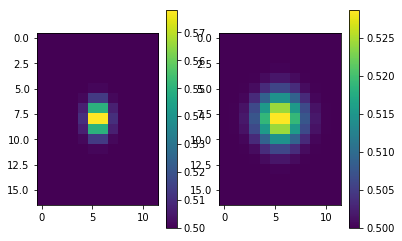

In [4]:
from SWESimulators import LxF
importlib.reload(LxF)

nx = 10
ny = 15
num_ghost_cells = 1
dt = 0.01
g = 9.81

h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ny, num_ghost_cells)
plt.figure()
plt.subplot(121)
plt.imshow(h0)
plt.colorbar()

sim = LxF.LxF(h0, hu0, hv0, \
                nx, ny, \
                dx, dy, dt, \
                g)

t = sim.step(0.02)
h1, hu1, hv1 = sim.download()

plt.subplot(122)
plt.imshow(h1)
plt.colorbar()